In [1]:
import pandas as pd

### Data Loading

In [2]:
# claim
#fake_claim = pd.read_csv('data/fake/ClaimFake05.csv')

csv_file_list = ["data/fake/ClaimFake05.csv", "data/fake/ClaimFake07.csv"]

list_of_dataframes = []
for filename in csv_file_list:
    list_of_dataframes.append(pd.read_csv(filename))

fake_claim = pd.concat(list_of_dataframes)


csv_file_list = ["data/real/ClaimReal05.csv", "data/real/ClaimReal07.csv", "data/real/ClaimReal09.csv", "data/real/ClaimReal11.csv"]

list_of_dataframes = []
for filename in csv_file_list:
    list_of_dataframes.append(pd.read_csv(filename))

real_claim = pd.concat(list_of_dataframes)

In [3]:
real_claim.shape

real_claim.head()

,Unnamed: 0,fact_check_url,news_url,title
0,100000,who.int,https://www.who.int/news-room/q-a-detail/q-a-o...,"""How large does a meeting or event need to be ..."
1,100001,who.int,https://www.who.int/news-room/q-a-detail/q-a-o...,"""Does WHO recommend that all international mas..."
2,100002,who.int,https://www.who.int/news-room/q-a-detail/q-a-o...,"""What factors should organizers and health aut..."
3,100003,who.int,https://www.who.int/news-room/q-a-detail/q-a-o...,"""What if my organization does not have the exp..."
4,100004,who.int,https://www.who.int/news-room/q-a-detail/q-a-o...,"""If we go ahead with an international mass gat..."


In [4]:
# news
# fake news 925
csv_file_list = ["data/fake/NewsFake05.csv", "data/fake/NewsFake07.csv", "data/fake/NewsFake09.csv", "data/fake/NewsFake11.csv"]

list_of_dataframes = []
for filename in csv_file_list:
    list_of_dataframes.append(pd.read_csv(filename))

fake_news = pd.concat(list_of_dataframes)

# real news 4532
csv_file_list = ["data/real/NewsReal05.csv", "data/real/NewsReal07.csv", "data/real/NewsReal09.csv", "data/real/NewsReal11.csv"]

list_of_dataframes = []
for filename in csv_file_list:
    list_of_dataframes.append(pd.read_csv(filename))

real_news = pd.concat(list_of_dataframes)

In [5]:
# combine claim and news, label data
fake_claim['label'] = 1
real_claim['label'] = 0
fake_news['label'] = 1
real_news['label'] = 0

In [6]:
df = pd.concat([fake_claim[['title','label']],real_claim[['title','label']],fake_news[['title','label']],real_news[['title','label']]])

In [7]:
corpus = [t for t in df['title']]

corpus[1]

'"Only older adults and young people are at risk"'

In [8]:
#from sklearn.feature_extraction.text import CountVectorizer

#tf = CountVectorizer()

#document_tf_matrix = tf.fit_transform(corpus).todense()



In [9]:
#from math import log

#def idf(frequency_matrix):
#    idf =  float(len(document_tf_matrix)) / sum(frequency_matrix > 0)
#    return [log(i) for i in df.getA()[0]]

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
document_tfidf_matrix = tfidf.fit_transform(corpus)


In [11]:
#document_tfidf_matrix = document_tfidf_matrix.todense()

#document_tfidf_matrix.shape
df.shape

(5975, 2)

In [12]:
from sklearn.model_selection import train_test_split
X = document_tfidf_matrix
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [13]:
# Oversampling
# Counter({0: 4018, 1: 4018})
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(y_over))

Counter({0: 4018, 1: 4018})


In [14]:
# GBM model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve

model = GradientBoostingClassifier(
                                n_estimators=1000, 
                                learning_rate=.01)

model.fit(X_over, y_over)
y_hat = model.predict(X_test)

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, y_hat)

precision

array([0.15983264, 0.57195572, 1.        ])

In [16]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision = precision_score(y_hat, y_test)
print('Precision: %.3f' % precision)

recall = recall_score(y_hat, y_test, average='binary')
print('Recall: %.3f' % recall)

Precision: 0.812
Recall: 0.572


In [23]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

print(Counter(y_smote))

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)
rf.fit(X_smote, y_smote)
                                     
# Test Prediction
pred = rf.predict(X_test)


precision = precision_score(pred, y_test)
print('Precision: %.3f' % precision)

recall = recall_score(pred, y_test, average='binary')
print('Recall: %.3f' % recall)

Precision: 0.639
Recall: 0.910


In [37]:
model = GradientBoostingClassifier(
                                n_estimators=1000, 
                                learning_rate=.01)

model.fit(X_smote, y_smote)
y_hat = model.predict_proba(X_test)

precision = precision_score(y_hat, y_test)
print('Precision: %.3f' % precision)

recall = recall_score(y_hat, y_test, average='binary')
print('Recall: %.3f' % recall)

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

In [32]:

# calculate model precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_hat)

precision

array([0.15983264, 0.70466321, 1.        ])

In [38]:
y_hat

array([[0.13642321, 0.86357679],
       [0.93361519, 0.06638481],
       [0.94522646, 0.05477354],
       ...,
       [0.95356096, 0.04643904],
       [0.94522646, 0.05477354],
       [0.9101543 , 0.0898457 ]])

In [ ]:
grid = {'max_depth': [2,3,4,5],
        'subsample': [0.1, 0.5, 0.8]}

gb_gridsearch = GridSearchCV(estimator=model, param_grid=grid, 
                             cv=5, verbose=0, return_train_score=True)

gb_gridsearch.fit(X_train, y_train)

# and after some hours...
df_gridsearch = pd.DataFrame(gb_gridsearch.cv_results_)

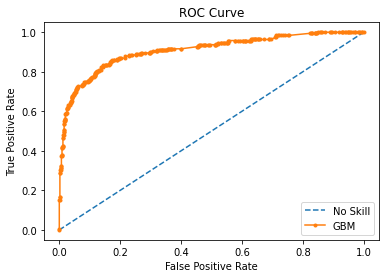

In [40]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

pos_probs = y_hat[:, 1]
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='GBM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()